<img align="center" src="img/course.png" width="800">

# 16720 (B)  Object Tracking in Videos - Assignment 6 - Q2
    Instructor: Kris                          TAs: Arka, Rohan, Rawal, Sheng-Yu, Jinkun


In [ ]:
# Libraries

import numpy as np
from scipy.interpolate import RectBivariateSpline
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

## Q2: Matthew-Bakers Inverse Compositional Alignment with Affine Matrix

### Q2.1: Implementation (10 PT write-up, 20 PT implementation)
Now we will implement the Matthew-Bakers tracker to alleviate the computational costs of the the Lucas-Kanade tracker, as it only calculates the Hessian and Jacobian once per each video. Write the function with the following function signature:

```
            M = InverseCompositionAffine(It, It1, rect)
```
that computes the optimal local motion represented by a $2x3$ affine transformation matrix $M$ from frame $I_t$ to frame $I_{t+1}$ that minimizes

$$
\begin{gathered}
\mathcal{L}=\sum_{\mathbf{x}}[\mathbf{T}(\mathbf{x})-\mathbf{I}(\mathbf{W}(\mathbf{x} ; \mathbf{p}))]^{2}. 
\end{gathered}
$$

The inputs are structured identically to Q1.2, but you should replace the forward alignment algorithm with the inverse compositional alignment algorithm. You may also find these materials useful: [link](https://www.ri.cmu.edu/pub_files/pub3/baker_simon_2002_3/baker_simon_2002_3.pdf) and [link](https://www.ri.cmu.edu/pub_files/pub3/baker_simon_2003_3/baker_simon_2003_3.pdf).

<span style='color:red'>**Output:**</span> In your write-up: Please include the results of the algorithm on all five videos we have provided along with your code. Compare the results of the Matthew-Bakers Tracker with the previous algorithms you have implemented. How do your algorithms perform on each video? What are the differences of the three algorithms in terms of performance and why do they have those differences? At what point does the algorithm break down and why does this happen?

In [ ]:

def InverseCompositionAffine(It, It1, rect, thresh=.025, maxIt=100):
  '''
  Q2.1: Matthew-Bakers Inverse Compositional Alignment with Affine MAtrix

    Inputs: 
      It: template image
      It1: Current image
      rect: Current position of the object
      (top left, bottom right coordinates, x1, y1, x2, y2)
      thresh: Stop condition when dp is too small
      maxIt: Maximum number of iterations to run
      
    Outputs:
      M: Affine mtarix (2x3)
  '''

  # Set thresholds (you probably want to play around with the values)
  M = np.array([[1., 0, 0], [0, 1.,0]])
  threshold = thresh
  maxIters = maxIt
  i = 0
  x1, y1, x2, y2 = rect
  num_x = int(x2-x1)#//2
  num_y = int(y2-y1)#//2
  dp = np.inf

  # Index for the image
  img_x = np.arange(It.shape[1])
  img_y = np.arange(It.shape[0])

  # Precompute

  # 1. Calculate the gradient of the template
  x_template = np.linspace(x1, x2, num_x)
  y_template = np.linspace(y1, y2, num_y)
  x_t_pts, y_t_pts = np.meshgrid(x_template, y_template)
  homo_pts = np.vstack((x_t_pts.flatten(), y_t_pts.flatten(), np.ones_like(y_t_pts).flatten()))
  temp_interp = RectBivariateSpline(img_y, img_x, It)
  grad_temp_x = temp_interp.ev(y_t_pts, x_t_pts, dy = 1)
  grad_temp_y = temp_interp.ev(y_t_pts, x_t_pts, dx = 1)

  # 2-3. Evaluate the Jacobian at x
  A1 = (x_t_pts * grad_temp_x).flatten()
  A2 = (y_t_pts * grad_temp_x).flatten()
  A4 = (x_t_pts * grad_temp_y).flatten()
  A5 = (y_t_pts * grad_temp_y).flatten()
  A  = np.vstack((A1, A2, grad_temp_x.flatten(), A4, A5, grad_temp_y.flatten())).T

  # 4. Compute the Hessian
  H = A.T @ A

  temp_img = temp_interp.ev(y_t_pts, x_t_pts)
  curr_img_interp = RectBivariateSpline(img_y, img_x, It1)
  while np.sum(dp**2) > thresh and i < maxIters:
    # 5. Warp the Points to the Current image
    wrp_pts = M @ homo_pts
    wrp_pts = M @ homo_pts
    I_w_x = curr_img_interp.ev(wrp_pts[1], wrp_pts[0])

    # Compute the error image
    E_x = I_w_x - temp_img.flatten()
    #print(f"Error: {np.sum(E_x)}")

    # Calculate change in the parameters dp
    dp = np.linalg.inv(H) @ A.T @ E_x.flatten()

    # Calculate dM
    dM = np.eye(3, dtype = np.float64)
    dM += np.vstack((dp.reshape(2,3), np.array([0,0,0])))

    # Calculate the new M
    M = M @ np.linalg.inv(dM)

    # Increment Count
    i += 1

  return M




In [ ]:
# Test your algorithm and visualize results!

# Load data
import os

data_names = ["car1", "car2", "landing", "race", "ballet"]

# Load data
data_name = 'landing' # could choose from (car1, car2, landing, race, ballet)
for data_name in data_names:
    data = np.load('./data/%s.npy' % data_name)

    # obtain the initial rect with format (x1, y1, x2, y2)
    if data_name == 'car1':
        initial = np.array([170, 130, 290, 250])   
    elif data_name == 'car2':
        initial = np.array([59, 116, 145, 151])    
    elif data_name == 'landing':
        initial = np.array([440, 80, 560, 140])     
    elif data_name == 'race':
        initial = np.array([170, 270, 300, 370])
    elif data_name == 'ballet':
        initial = np.array([700, 210, 775, 300])     
    else:
        assert False, 'the data name must be one of (car1, car2, landing, race, ballet)'

    thresh = 0.25
    iter   = 100
    # if data_name == "car2":
    #     thresh = 0.75
    #     iter = 10
    if data_name == "ballet":
        thresh = 0.075
        iter = 100
    # else:
    #     thresh = 0.025
    #     iter = 100

    numFrames = data.shape[2]
    w = initial[2] - initial[0]
    h = initial[3] - initial[1]

    # loop over frames
    rects = []
    rects.append(initial)


    out_folder = f"results/q2.1/{data_name}/"
    if not os.path.exists(out_folder):
        os.mkdir(out_folder)

    for i in range(numFrames-1):

        It = data[:,:,i]
        It1 = data[:,:,i+1]
        rect = rects[i]

        # run algorithm and collect rects
        M = InverseCompositionAffine(It, It1, rect, thresh=thresh, maxIt=iter)
        corners = np.array([[rect[0], rect[1], 1], 
                            [rect[2], rect[3], 1]]).transpose()
        newRect = np.matmul(M, corners).transpose().reshape((4, ))
        rects.append(newRect)

        # Visualize
        fig = plt.figure(1)
        ax = fig.add_subplot(111)
        ax.add_patch(patches.Rectangle((rect[0], rect[1]), rect[2]-rect[0]+1, rect[3]-rect[1]+1, linewidth=2, edgecolor='red', fill=False))
        plt.imshow(It1, cmap='gray')
        if i%5 == 0:
            plt.axis("off")
            plt.savefig(out_folder + f"{i}.png", bbox_inches='tight')
        plt.show()
        ax.clear()

In [ ]:
# For some transparency: we evaluate on multiple frames in a given video starting from the first frame.
# We then compare against the reference implementation and calculate the sum of all differences.
# You should not need to tune anything for the autograding. We pass in the same hyperparameters for you.


### Q2.2: Comparing Your Algorithms (write-up only, 10 PT)
Compare the results of the Matthew-Bakers Tracker with the previous algorithms you have implemented. How do your algorithms perform on each video? What are the differences of the three algorithms in terms of performance and why do we have those differences?  At what point does the algorithm break down and why does this happen?

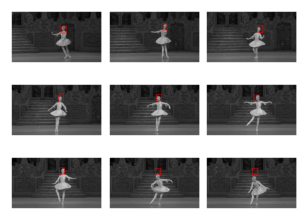

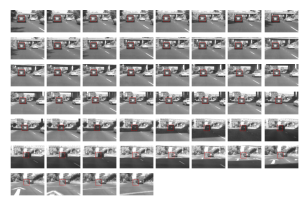

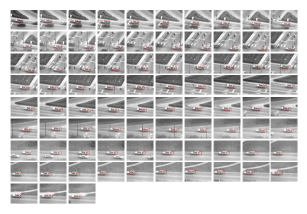

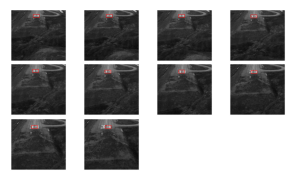

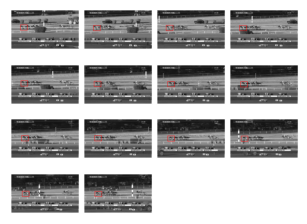

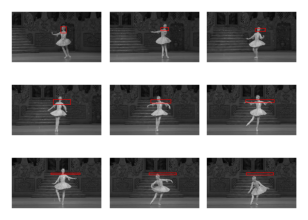

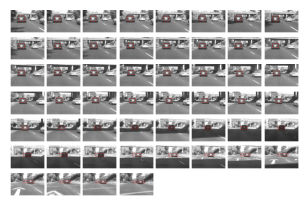

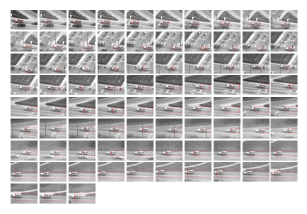

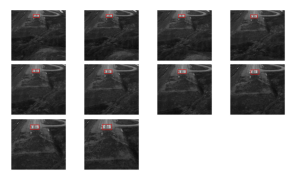

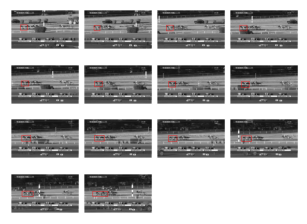

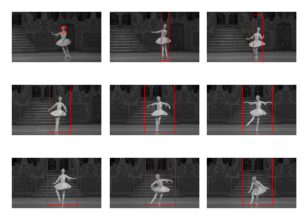

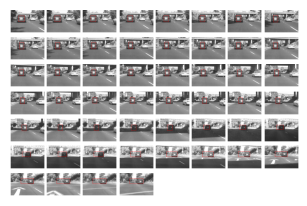

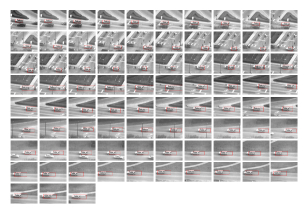

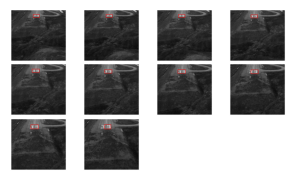

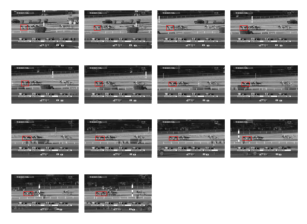

In [45]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from math import ceil
from matplotlib import image

# Add code to make a grid of each result
def create_res_grid(directory):
    for root, dirs, files in os.walk(directory):
        for dir in dirs:
            # Add the files
            files = {}
            for file in os.listdir(directory + dir):
                if int(file.split(".")[0]) % 5 == 0:
                    files[int(file.split(".")[0])] = directory + dir + "/" + file

            # Make the grid
            grid_size = ceil((len(files.keys())) ** 0.5)
            fig = plt.figure(1)
            fig.tight_layout()
            for idx, key in enumerate(sorted(files.keys())):
                plt.subplot(grid_size, grid_size, idx+1)
                plt.imshow(image.imread(files[key]))
                plt.axis("off")
                plt.subplots_adjust(left=0.05,right=0.5,top=0.5,bottom=0.05,wspace=0.05,hspace=0.05)

            # Save the figure
            fig.savefig(f"{directory}{dir}_grid_{directory[9:12]}.png", bbox_inches='tight')
            plt.show()
            plt.close()

# Make grid of Q1.1
create_res_grid("results/q1.1/")

# Make grid of Q1.2
create_res_grid("results/q1.2/")

# Make grid of Q2.1
create_res_grid("results/q2.1/")